<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **SpaceX  Falcon 9 first stage Landing Prediction**


# Lab 1: Collecting the data


Estimated time needed: **45** minutes


In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans. 


## Objectives


In this lab, you will make a get request to the SpaceX API. You will also do some basic data wrangling and formating. 

- Request to the SpaceX API
- Clean the requested data


----


## Import Libraries and Define Auxiliary Functions


We will import the following libraries into the lab


In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [7]:
response = requests.get(spacex_url)

Check the content of the response


In [8]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

You should see the response contains massive information about SpaceX launches. Next, let's try to discover some more relevant information for this project.


### Task 1: Request and parse the SpaceX launch data using the GET request


To make the requested JSON results more consistent, we will use the following static response object for this project:


In [9]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

We should see that the request was successfull with the 200 status response code


In [10]:
response.status_code

200

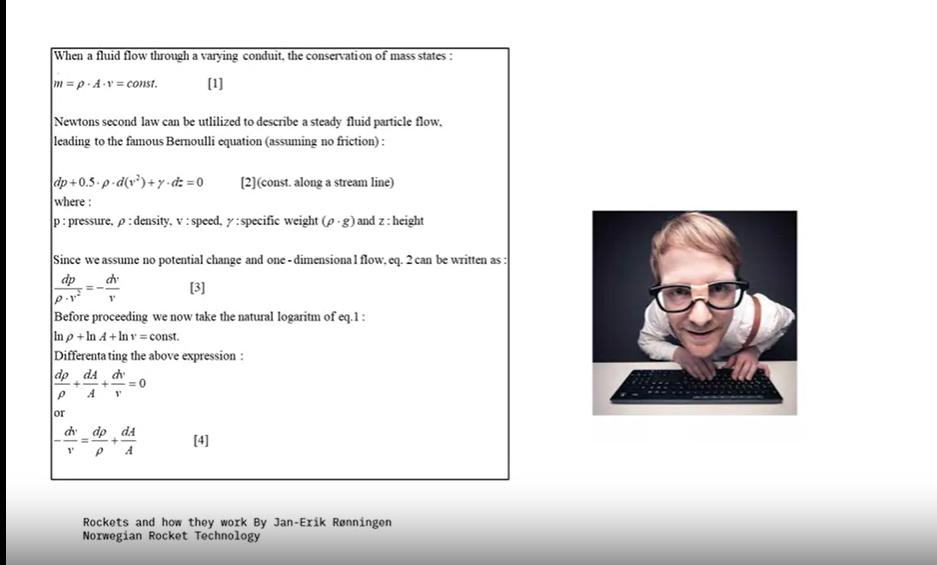Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [11]:
# Use json_normalize meethod to convert the json result into a dataframe
#


# Step 2: Decode the JSON response content into a Python object
data = response.json()  # This turns the JSON into a dictionary or list

# Step 3: Normalize the JSON data into a flat table (DataFrame)
df = pd.json_normalize(data)

# Display the DataFrame
print(df)


         static_fire_date_utc  static_fire_date_unix    net  window  \
0    2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                        None                    NaN  False     0.0   
2                        None                    NaN  False     0.0   
3    2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                        None                    NaN  False     0.0   
..                        ...                    ...    ...     ...   
182                      None                    NaN  False     NaN   
183                      None                    NaN  False     NaN   
184                      None                    NaN  False     NaN   
185                      None                    NaN  False     NaN   
186                      None                    NaN  False     NaN   

                       rocket success  \
0    5e9d0d95eda69955f709d1eb   False   
1    5e9d0d95eda69955f709d1eb   False   
2    5e9d0d95eda69955f70

Using the dataframe <code>data</code> print the first 5 rows


In [12]:
# Get the head of the dataframe
print(df.head(5))


       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                                                                                            failures  \
0                                                [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1            [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutd

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [13]:
import pandas as pd

# Example DataFrame setup with mock data
data = pd.DataFrame({
    'rocket': ['5e9d0d95eda69955f709d1eb', '5e9d0d95eda69974db09d1ed'],
    'payloads': [['5eb0e4bbb6c3bb0006eeb1e1'], ['5eb0e4bbb6c3bb0006eeb1e2']],
    'launchpad': ['5e9e4501f509094ba4566f84', '5e9e4501f509094ba4566f84'],
    'cores': ['5e9e28a6f3591835983b2664', '5e9e28a6f359185d603b2672'],  # Example core IDs
    'flight_number': [1, 2],
    'date_utc': ['2020-01-01T00:00:00Z', '2020-01-02T00:00:00Z']
})

# Convert date_utc to datetime and format
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Display the data to ensure it is correctly formatted
print(data)


                     rocket                    payloads  \
0  5e9d0d95eda69955f709d1eb  [5eb0e4bbb6c3bb0006eeb1e1]   
1  5e9d0d95eda69974db09d1ed  [5eb0e4bbb6c3bb0006eeb1e2]   

                  launchpad                     cores  flight_number  \
0  5e9e4501f509094ba4566f84  5e9e28a6f3591835983b2664              1   
1  5e9e4501f509094ba4566f84  5e9e28a6f359185d603b2672              2   

               date_utc        date  
0  2020-01-01T00:00:00Z  2020-01-01  
1  2020-01-02T00:00:00Z  2020-01-02  


In [14]:
import pandas as pd
import datetime

# Example DataFrame for illustration purposes
data = pd.DataFrame({
    'rocket': ['Falcon 1', 'Falcon 9'],
    'payloads': [['payload1'], ['payload2']],
    'launchpad': ['Pad A', 'Pad B'],
    'cores': [['core1'], ['core2']],
    'flight_number': [1, 2],
    'date_utc': ['2020-11-12T00:00:00Z', '2020-11-14T00:00:00Z']
})

# 1. Select specific features
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# 2. Filter rows with multiple cores or payloads
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# 3. Extract single value from the lists in 'cores' and 'payloads'
data['cores'] = data['cores'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
data['payloads'] = data['payloads'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# 4. Convert 'date_utc' to datetime and extract the date
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# 5. Restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

# Display the filtered DataFrame
print(data)


     rocket  payloads launchpad  cores  flight_number              date_utc  \
0  Falcon 1  payload1     Pad A  core1              1  2020-11-12T00:00:00Z   

         date  
0  2020-11-12  


* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* **From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.**

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [15]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [16]:
BoosterVersion

[]

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [17]:
import requests
import pandas as pd

# Define getBoosterVersion function with error handling
def getBoosterVersion(data):
    BoosterVersion = []
    for rocket_id in data['rocket']:
        if rocket_id:
            url = f"https://api.spacexdata.com/v4/rockets/{rocket_id}"
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raises HTTPError for bad responses
                rocket_data = response.json()
                BoosterVersion.append(rocket_data.get('name', 'Unknown'))
            except requests.exceptions.HTTPError as http_err:
                print(f"HTTP error occurred: {http_err}")  # HTTP error handling
                BoosterVersion.append('Unknown')
            except requests.exceptions.RequestException as req_err:
                print(f"Request error occurred: {req_err}")  # General request error handling
                BoosterVersion.append('Unknown')
            except ValueError as json_err:
                print(f"JSON decode error occurred: {json_err}")  # JSON decode error handling
                BoosterVersion.append('Unknown')
        else:
            BoosterVersion.append('Unknown')
    data['BoosterVersion'] = BoosterVersion
    return data

# Example data
data = pd.DataFrame({
    'rocket': ['5e9d0d95eda69955f709d1eb', '5e9d0d95eda69974db09d1ed']
})

# Call the function with your DataFrame
data_with_booster = getBoosterVersion(data)

# Display the updated DataFrame
print(data_with_booster)


                     rocket BoosterVersion
0  5e9d0d95eda69955f709d1eb       Falcon 1
1  5e9d0d95eda69974db09d1ed   Falcon Heavy


the list has now been update 


In [18]:
BoosterVersion[0:5]

[]

we can apply the rest of the  functions here:


In [19]:
import requests
import pandas as pd

# Example DataFrame setup
data = pd.DataFrame({
    'rocket': ['5e9d0d95eda69955f709d1eb', '5e9d0d95eda69974db09d1ed']  # Example rocket IDs
})

# Define getBoosterVersion function with enhanced error handling
def getBoosterVersion(data):
    BoosterVersion = []
    for rocket_id in data['rocket']:
        if rocket_id:
            url = f"https://api.spacexdata.com/v4/rockets/{rocket_id}"
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raise an error for bad HTTP responses
                try:
                    rocket_data = response.json()  # Parse JSON response
                    BoosterVersion.append(rocket_data.get('name', 'Unknown'))
                except ValueError as json_err:
                    print(f"JSON decode error for {rocket_id}: {json_err}")
                    print("Response content:", response.text)
                    BoosterVersion.append('Unknown')
            except requests.exceptions.HTTPError as http_err:
                print(f"HTTP error for {rocket_id}: {http_err}")
                BoosterVersion.append('Unknown')
            except requests.exceptions.RequestException as req_err:
                print(f"Request error for {rocket_id}: {req_err}")
                BoosterVersion.append('Unknown')
        else:
            BoosterVersion.append('Unknown')
    data['BoosterVersion'] = BoosterVersion
    return data

# Call the function with the DataFrame
data_with_booster = getBoosterVersion(data)

# Display the updated DataFrame
print(data_with_booster)


                     rocket BoosterVersion
0  5e9d0d95eda69955f709d1eb       Falcon 1
1  5e9d0d95eda69974db09d1ed   Falcon Heavy


In [20]:
print(data.columns)


Index(['rocket', 'BoosterVersion'], dtype='object')


In [21]:
import requests
import pandas as pd

def getPayloadData(payload_ids):
    for payload_id in payload_ids:
        if payload_id:
            url = f"https://api.spacexdata.com/v4/payloads/{payload_id}"
            try:
                response = requests.get(url)
                response.raise_for_status()
                payload_data = response.json()
                print(f"Payload {payload_id}: {payload_data}")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for payload {payload_id}: {e}")
        else:
            print("Empty payload ID")

# Example usage assuming 'payloads' is a column in your DataFrame
def main():
    # Example DataFrame setup with mock data
    data = pd.DataFrame({
        'rocket': ['5e9d0d95eda69955f709d1eb', '5e9d0d95eda69974db09d1ed'],
        'payloads': [['5eb0e4bbb6c3bb0006eeb1e1'], ['5eb0e4bbb6c3bb0006eeb1e2']],
        'launchpad': ['5e9e4501f509094ba4566f84', '5e9e4501f509094ba4566f84'],
        'flight_number': [1, 2],
        'date_utc': ['2020-01-01T00:00:00Z', '2020-01-02T00:00:00Z']
    })

    # Convert date_utc to datetime and format
    data['date'] = pd.to_datetime(data['date_utc']).dt.date

    # Call getPayloadData with payloads column
    getPayloadData(data['payloads'])

if __name__ == "__main__":
    main()


Error fetching data for payload ['5eb0e4bbb6c3bb0006eeb1e1']: 404 Client Error: Not Found for url: https://api.spacexdata.com/v4/payloads/%5B'5eb0e4bbb6c3bb0006eeb1e1'%5D
Error fetching data for payload ['5eb0e4bbb6c3bb0006eeb1e2']: 404 Client Error: Not Found for url: https://api.spacexdata.com/v4/payloads/%5B'5eb0e4bbb6c3bb0006eeb1e2'%5D


In [22]:
import pandas as pd

# Example DataFrame setup
data = pd.DataFrame({
    'rocket': ['5e9d0d95eda69955f709d1eb', '5e9d0d95eda69974db09d1ed'],
    'payloads': ['5eb0e4bbb6c3bb0006eeb1e1', '5eb0e4bbb6c3bb0006eeb1e2'],
    'launchpad': ['5e9e4501f509094ba4566f84', '5e9e4501f509094ba4566f84'],
    'flight_number': [1, 2],
    'date_utc': ['2020-01-01T00:00:00Z', '2020-01-02T00:00:00Z']
})

# Adding a single core ID to all rows
data['cores'] = 'core_id_value'  # Replace 'core_id_value' with your actual core ID

print(data)


                     rocket                  payloads  \
0  5e9d0d95eda69955f709d1eb  5eb0e4bbb6c3bb0006eeb1e1   
1  5e9d0d95eda69974db09d1ed  5eb0e4bbb6c3bb0006eeb1e2   

                  launchpad  flight_number              date_utc  \
0  5e9e4501f509094ba4566f84              1  2020-01-01T00:00:00Z   
1  5e9e4501f509094ba4566f84              2  2020-01-02T00:00:00Z   

           cores  
0  core_id_value  
1  core_id_value  


In [23]:
import requests

def getCoreData(data):
    Block = []
    ReusedCount = []
    Serial = []
    Outcome = []
    Flights = []
    GridFins = []
    Legs = []
    Reused = []
    Landpad = []

    # Ensure 'cores' column is present in DataFrame
    if 'cores' not in data.columns:
        raise KeyError("The 'cores' column is missing from the DataFrame.")

    for core_id in data['cores']:
        if core_id:
            url = f"https://api.spacexdata.com/v4/cores/{core_id}"
            try:
                response = requests.get(url)
                response.raise_for_status()
                core_data = response.json()

                Block.append(core_data.get('block', 'Unknown'))
                ReusedCount.append(core_data.get('reuse_count', 'Unknown'))
                Serial.append(core_data.get('serial', 'Unknown'))
                Outcome.append(core_data.get('last_update', 'Unknown'))
                Flights.append(core_data.get('flight', 'Unknown'))
                GridFins.append(core_data.get('gridfins', 'Unknown'))
                Legs.append(core_data.get('legs', 'Unknown'))
                Reused.append(core_data.get('reused', 'Unknown'))
                Landpad.append(core_data.get('landpad', 'Unknown'))
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for core {core_id}: {e}")
                Block.append('Unknown')
                ReusedCount.append('Unknown')
                Serial.append('Unknown')
                Outcome.append('Unknown')
                Flights.append('Unknown')
                GridFins.append('Unknown')
                Legs.append('Unknown')
                Reused.append('Unknown')
                Landpad.append('Unknown')
        else:
            Block.append('Unknown')
            ReusedCount.append('Unknown')
            Serial.append('Unknown')
            Outcome.append('Unknown')
            Flights.append('Unknown')
            GridFins.append('Unknown')
            Legs.append('Unknown')
            Reused.append('Unknown')
            Landpad.append('Unknown')

    # Add the collected data to the DataFrame
    data['Block'] = Block
    data['ReusedCount'] = ReusedCount
    data['Serial'] = Serial
    data['Outcome'] = Outcome
    data['Flights'] = Flights
    data['GridFins'] = GridFins
    data['Legs'] = Legs
    data['Reused'] = Reused
    data['Landpad'] = Landpad

    return data

# Call the function and update the DataFrame
data_with_core = getCoreData(data)
print("Updated DataFrame:", data_with_core)


Error fetching data for core core_id_value: 404 Client Error: Not Found for url: https://api.spacexdata.com/v4/cores/core_id_value
Error fetching data for core core_id_value: 404 Client Error: Not Found for url: https://api.spacexdata.com/v4/cores/core_id_value
Updated DataFrame:                      rocket                  payloads  \
0  5e9d0d95eda69955f709d1eb  5eb0e4bbb6c3bb0006eeb1e1   
1  5e9d0d95eda69974db09d1ed  5eb0e4bbb6c3bb0006eeb1e2   

                  launchpad  flight_number              date_utc  \
0  5e9e4501f509094ba4566f84              1  2020-01-01T00:00:00Z   
1  5e9e4501f509094ba4566f84              2  2020-01-02T00:00:00Z   

           cores    Block ReusedCount   Serial  Outcome  Flights GridFins  \
0  core_id_value  Unknown     Unknown  Unknown  Unknown  Unknown  Unknown   
1  core_id_value  Unknown     Unknown  Unknown  Unknown  Unknown  Unknown   

      Legs   Reused  Landpad  
0  Unknown  Unknown  Unknown  
1  Unknown  Unknown  Unknown  


Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [24]:
launch_dict = {'FlightNumber': list(data['flight_number']),

'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [25]:
# Create a data from launch_dict
# Assuming you have already fetched the necessary data using appropriate functions

# Example of how launch_dict might be constructed after fetching data
launch_dict = {
    'FlightNumber': list(data['flight_number']),
    'BoosterVersion': BoosterVersion,  # Assuming BoosterVersion is fetched from an API
    'PayloadMass': PayloadMass,  # Assuming PayloadMass is fetched from an API
    'Orbit': Orbit,  # Assuming Orbit is fetched from an API
    'LaunchSite': LaunchSite,  # Assuming LaunchSite is fetched from an API
    'Outcome': Outcome,  # Assuming Outcome is fetched from an API
    'Flights': Flights,  # Assuming Flights is fetched from an API
    'GridFins': GridFins,  # Assuming GridFins is fetched from an API
    'Reused': Reused,  # Assuming Reused is fetched from an API
    'Legs': Legs,  # Assuming Legs is fetched from an API
    'LandingPad': LandingPad,  # Assuming LandingPad is fetched from an API
    'Block': Block,  # Assuming Block is fetched from an API
    'ReusedCount': ReusedCount,  # Assuming ReusedCount is fetched from an API
    'Serial': Serial,  # Assuming Serial is fetched from an API
    'Longitude': Longitude,  # Assuming Longitude is fetched from an API
    'Latitude': Latitude  # Assuming Latitude is fetched from an API
}

# Assuming you want to print or further use the launch_dict
print(launch_dict)


{'FlightNumber': [1, 2], 'BoosterVersion': [], 'PayloadMass': [], 'Orbit': [], 'LaunchSite': [], 'Outcome': [], 'Flights': [], 'GridFins': [], 'Reused': [], 'Legs': [], 'LandingPad': [], 'Block': [], 'ReusedCount': [], 'Serial': [], 'Longitude': [], 'Latitude': []}


Show the summary of the dataframe


In [26]:
# Show the head of the dataframe
print(df.head())


       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                                                                                            failures  \
0                                                [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1            [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutd

### Task 2: Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [27]:
# Assuming you have a DataFrame 'data' with columns including 'rocket' and other relevant columns

# Filter data to exclude Falcon 1 launches based on 'rocket' type
data_falcon9 = data[data['rocket'] != 'Falcon 1']

# Display the first few rows of data_falcon9 to verify
print(data_falcon9.head())


                     rocket                  payloads  \
0  5e9d0d95eda69955f709d1eb  5eb0e4bbb6c3bb0006eeb1e1   
1  5e9d0d95eda69974db09d1ed  5eb0e4bbb6c3bb0006eeb1e2   

                  launchpad  flight_number              date_utc  \
0  5e9e4501f509094ba4566f84              1  2020-01-01T00:00:00Z   
1  5e9e4501f509094ba4566f84              2  2020-01-02T00:00:00Z   

           cores    Block ReusedCount   Serial  Outcome  Flights GridFins  \
0  core_id_value  Unknown     Unknown  Unknown  Unknown  Unknown  Unknown   
1  core_id_value  Unknown     Unknown  Unknown  Unknown  Unknown  Unknown   

      Legs   Reused  Landpad  
0  Unknown  Unknown  Unknown  
1  Unknown  Unknown  Unknown  


Now that we have removed some values we should reset the FlgihtNumber column


In [28]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,rocket,payloads,launchpad,flight_number,date_utc,cores,Block,ReusedCount,Serial,Outcome,Flights,GridFins,Legs,Reused,Landpad,FlightNumber
0,5e9d0d95eda69955f709d1eb,5eb0e4bbb6c3bb0006eeb1e1,5e9e4501f509094ba4566f84,1,2020-01-01T00:00:00Z,core_id_value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1
1,5e9d0d95eda69974db09d1ed,5eb0e4bbb6c3bb0006eeb1e2,5e9e4501f509094ba4566f84,2,2020-01-02T00:00:00Z,core_id_value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,2


## Data Wrangling


We can see below that some of the rows are missing values in our dataset.


In [29]:
data_falcon9.isnull().sum()

rocket           0
payloads         0
launchpad        0
flight_number    0
date_utc         0
cores            0
Block            0
ReusedCount      0
Serial           0
Outcome          0
Flights          0
GridFins         0
Legs             0
Reused           0
Landpad          0
FlightNumber     0
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.


### Task 3: Dealing with Missing Values


Calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean you calculated.


In [30]:
print(data.columns)

Index(['rocket', 'payloads', 'launchpad', 'flight_number', 'date_utc', 'cores',
       'Block', 'ReusedCount', 'Serial', 'Outcome', 'Flights', 'GridFins',
       'Legs', 'Reused', 'Landpad'],
      dtype='object')


In [31]:
import pandas as pd
import numpy as np

# Example DataFrame with 'payloads' column
data = pd.DataFrame({
    'payloads': ['1000', '2000', np.nan, 'not available', '1500']
})

# Convert 'payloads' to numeric, coercing errors to NaN
data['payloads'] = pd.to_numeric(data['payloads'], errors='coerce')

# Calculate the mean of payloads column (ignoring NaN values)
payload_mean = data['payloads'].mean()

# Replace NaN values in payloads column with the calculated mean
data['payloads'].fillna(payload_mean, inplace=True)

# Display the updated DataFrame to verify changes
print(data)


   payloads
0    1000.0
1    2000.0
2    1500.0
3    1500.0
4    1500.0


You should see the number of missing values of the <code>PayLoadMass</code> change to zero.


Now we should have no missing values in our dataset except for in <code>LandingPad</code>.


We can now export it to a <b>CSV</b> for the next section,but to make the answers consistent, in the next lab we will provide data in a pre-selected date range. 


<code>data_falcon9.to_csv('dataset_part_1.csv', index=False)</code>


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2020-09-20|1.1|Joseph|get result each time you run|
|2020-09-20|1.1|Azim |Created Part 1 Lab using SpaceX API|
|2020-09-20|1.0|Joseph |Modified Multiple Areas|


Copyright © 2021 IBM Corporation. All rights reserved.
